In [1]:
# KOLMINKERTAINEN EKSPONENTIAALINEN TASOITUSMALLI

# HUOMIOI SEKÄ TRENDIN ETTÄ KAUSIVAIHTELUN. 

# Kolminkertaista eksponentiaalista tasoitusta kutsutaan myös Holt-Winterin malliksi. Eksponentiaalisen tasoituksen 
# mallit (yksinkertainen, kaksinkertainen ja kolminkertainen) ovat erityisen suosittuja liiketaloudessa kysynnän 
# ennustamisessa. Mallit ovat helppokäyttöisiä, nopeasti laskettavissa ja helposti päivitettävissä uusien havaintojen myötä.

# Holt-Winterin malli huomioi sekä trendin että kausivaihtelun.
# Eksponentiaalinen tasoitus löytyy statsmodels.tsa-kirjastosta.

import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.api import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import warnings
import itertools
import numpy as np
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
df=pd.read_excel('Saapuneet puhelut viikkotasolla.xlsx')
df

,Date,Saapuneet
0,2017-12-10,663
1,2017-12-17,941
2,2017-12-24,658
3,2017-12-31,1206
4,2018-01-07,991
...,...,...
161,2021-01-10,2505
162,2021-01-17,3626
163,2021-01-24,2996
164,2021-01-31,3719


In [3]:
df.index = pd.to_datetime(df['Date'],format="%Y-%m")
df=df.drop('Date',axis=1)
df

,Saapuneet
Date,
2017-12-10,663
2017-12-17,941
2017-12-24,658
2017-12-31,1206
2018-01-07,991
...,...
2021-01-10,2505
2021-01-17,3626
2021-01-24,2996


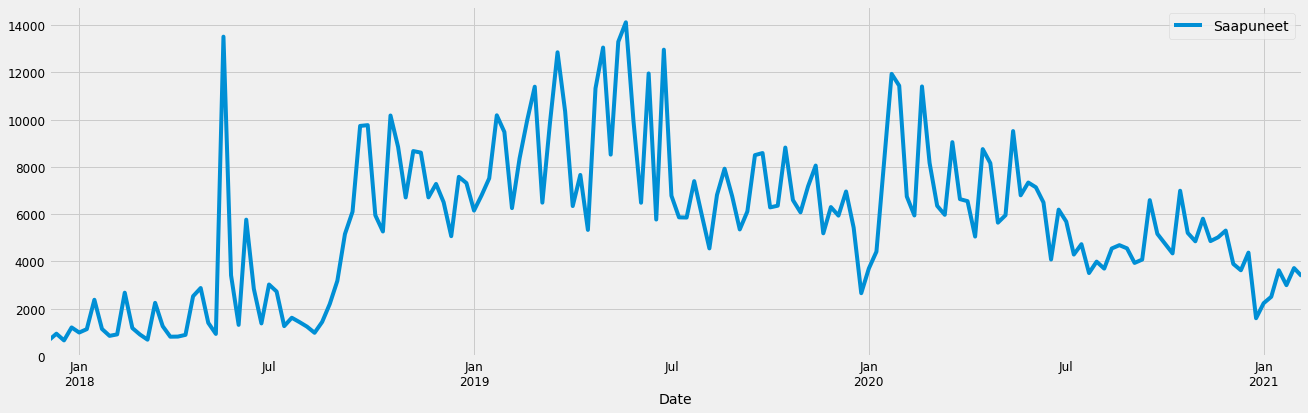

In [4]:
# Visualizing Time Series Data
df.plot(figsize=(20, 6))
plt.show()

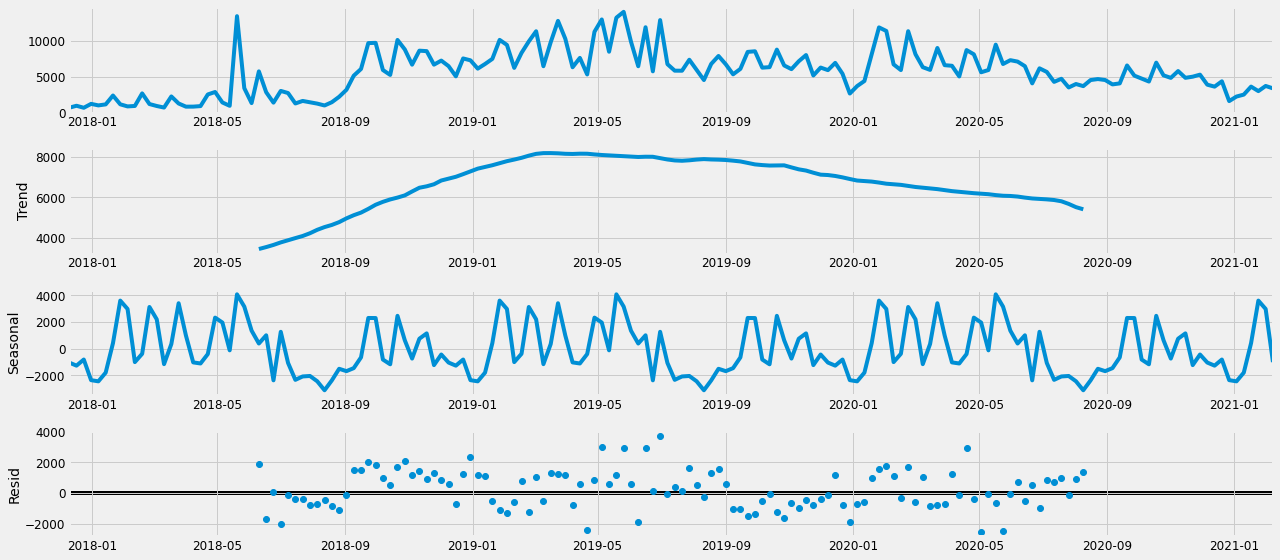

In [5]:
# Aikasarjan vaihtelua aiheuttavien komponenttien erottelu
# Observed=alkuperäinen aikasarja, Trend=trendi, Seasonal=kausivaihtelu,
# Residual=muu kuin trendiin ja kausivaihteluun liittyvä vaihtelu

# Tuloksena saan neljä kuviota:
# alkuperäinen aikasarja
# aikasarjasta erotettu trendi
# aikasarjan kausivaihtelu
# aikasarjan jäljelle jäänyt osa trendin ja kausivaihtelun poistamisen jälkeen.

# Visualizing Time Series Data
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
plt.show()

In [6]:
#Mallin sovitus
#Ennustemalli sovitetaan (fit()) dataan. Tuloksena saadaan olio (tässä olen antanut oliolle nimeksi malli), joka sisältää monenlaista tietoa mallista.
#Trendiin (trend) käytän summamallia (add), jossa trendi on aikasarjaan lisättävä termi. Tämä on suositeltavin vaihtoehto.
#Kausivaihteluun (seasonal) käytän summamallia (add) tai tulomallia (mul). Tulomallissa kausivaihtelu ilmenee kertoimina. Tässä olen kokeillut myös summamallia, mutta tulomalli osoittautui paremmaksi.
#seasonal_periods-parametrille käytän arvoa 20, koska kausivaihtelu esiintyy 20 viikon jaksoissa.
#freq-parametrille käytän arvoa 'W', koska kyseessä on viikkodata. Lisätietoa freq-parametrin mahdollisista arvoista https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
malli = ExponentialSmoothing(df['Saapuneet'], trend = 'add', seasonal = 'mul', 
                             seasonal_periods = 20, freq='W').fit()

In [7]:
# malli-olion avulla saan mallin mukaan simuloidut ennusteet (fittedvalues) jo toteutuneille ajankohdille
df['Ennuste'] = malli.fittedvalues
df

,Saapuneet,Ennuste
Date,,
2017-12-10,663,673.756482
2017-12-17,941,970.917299
2017-12-24,658,688.750824
2017-12-31,1206,1279.651994
2018-01-07,991,1065.156498
...,...,...
2021-01-10,2505,5802.584242
2021-01-17,3626,4615.417650
2021-01-24,2996,6070.801178


<AxesSubplot:xlabel='Date'>

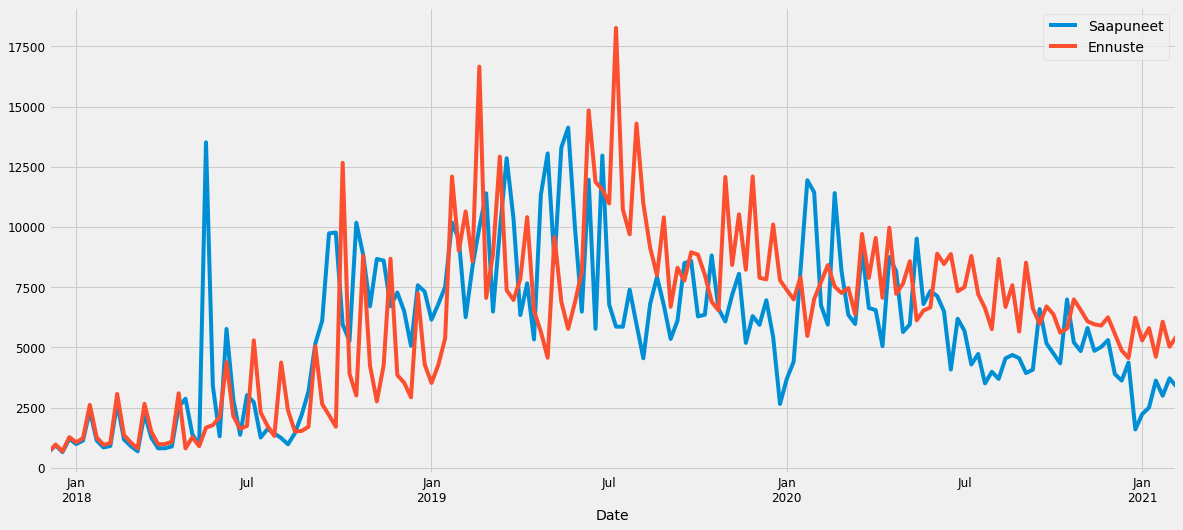

In [8]:
# Alkuperäinen aikasarja ja mallin mukaiset ennusteet samaan kaavioon
df.plot()

In [9]:
# Ennustevirheet (residuaalit) löytyvät malli-oliosta
df['Ennustevirhe'] = malli.resid
df

,Saapuneet,Ennuste,Ennustevirhe
Date,,,
2017-12-10,663,673.756482,-10.756482
2017-12-17,941,970.917299,-29.917299
2017-12-24,658,688.750824,-30.750824
2017-12-31,1206,1279.651994,-73.651994
2018-01-07,991,1065.156498,-74.156498
...,...,...,...
2021-01-10,2505,5802.584242,-3297.584242
2021-01-17,3626,4615.417650,-989.417650
2021-01-24,2996,6070.801178,-3074.801178


Text(0, 0.5, 'Ennustevirhe')

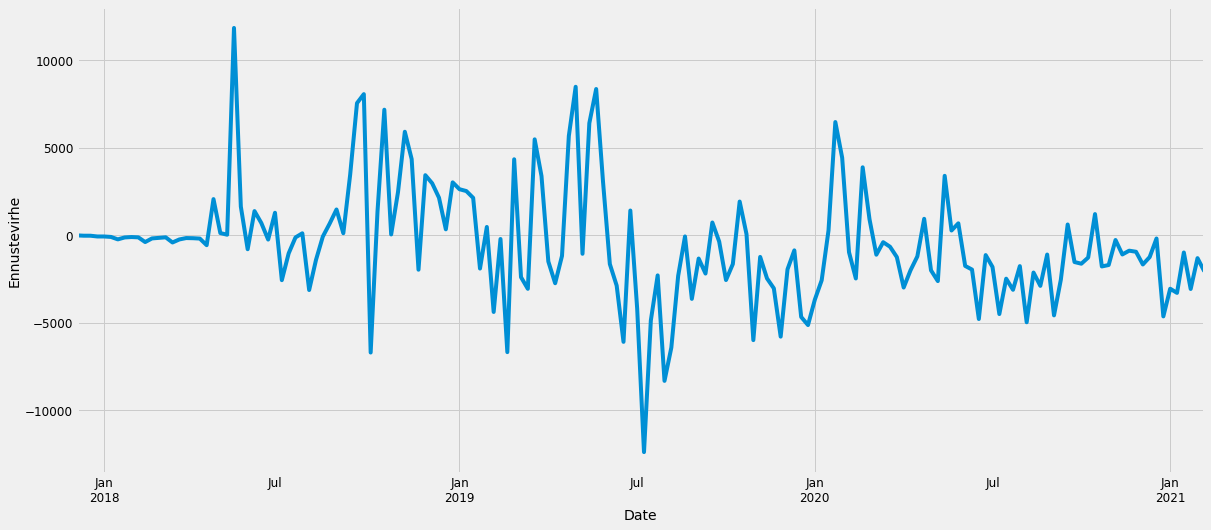

In [10]:
#Mallin tarkastelu
#Mallin hyvyyden tarkasteluun on monia tapoja. Tässä käytän
#ennustevirheiden aikasarjaa viivakaaviona
#ennusteiden ja toteutuneiden arvojen hajontakaaviota
#malliin liittyvää statistiikkaa, jonka saan summary()-toiminnolla.
#Huomaa erityisesti SSE (sum of squared errors). Mallia laskeva algoritmi yrittää saada SSE:n mahdollisimman pieneksi.
# Ennustevirheet aikasarjana
# On hyvä, jos ennustevirheiden aikasarjan vaihtelu on sattumanvaraista
df['Ennustevirhe'].plot()
plt.ylabel('Ennustevirhe')

Text(0, 0.5, 'Toteutunut kysyntä')

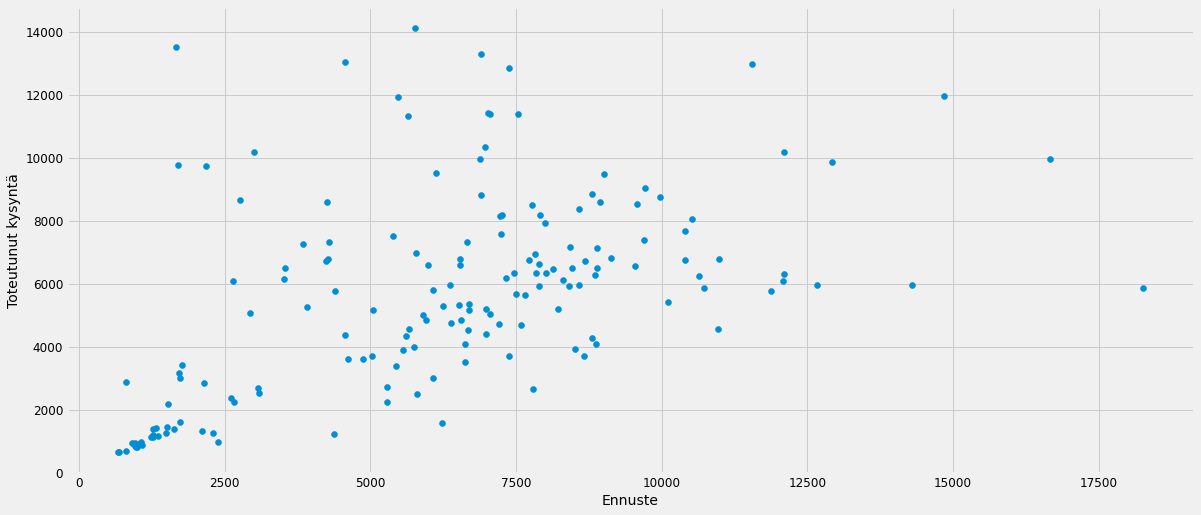

In [11]:
# Ennusteiden ja toteutuneiden kysyntöjen hajontakaavio
# Ennustemalli on sitä parempi, mitä paremmin pisteet seuraavat suoraa viivaa
# vasemmasta alakulmasta oikeaan yläkulmaan
plt.scatter(x = df['Ennuste'], y = df['Saapuneet'])
plt.xlabel('Ennuste')
plt.ylabel('Toteutunut kysyntä')

In [12]:
malli.summary()

Dep. Variable:,Saapuneet,No. Observations:,166
Model:,ExponentialSmoothing,SSE,1808172317.220
Optimized:,True,AIC,2737.797
Trend:,Additive,BIC,2812.484
Seasonal:,Multiplicative,AICC,2747.897
Seasonal Periods:,20,Date:,"Wed, 10 Feb 2021"
Box-Cox:,False,Time:,15:55:40
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0403571,alpha,True
smoothing_trend,0.0001,beta,True


In [13]:
#Ennusteiden laskeminen
#Ennustettavien ajankohtien aikaleimojen määrittämiseksi:
#Ensimmäisen ennustettavan ajankohdan aikaleiman täytyy olla aikasarjan viimeisintä aikaleimaa seuraava aikaleima.
#Ennustettavien ajankohtien lukumäärän voin määrittää periods-parametrilla.
#Ennustettavien ajankohtien frekvenssin on oltava sama kuin mallia sovitettaessa käytetty freq-parametrin arvo.
#Lisätietoa freq-parametrin mahdollisista arvoista https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
#Tarkistan viimeisen aikaleiman
df.tail()

,Saapuneet,Ennuste,Ennustevirhe
Date,,,
2021-01-10,2505,5802.584242,-3297.584242
2021-01-17,3626,4615.417650,-989.417650
2021-01-24,2996,6070.801178,-3074.801178
2021-01-31,3719,5030.769686,-1311.769686
2021-02-07,3380,5449.038705,-2069.038705


In [14]:
# Ennustettavien ajankohtien aikaleimat (alkupäivänä aikasarjan viimeistä aikaleimaa seuraava aikaleima)
index = pd.date_range('2021-02-14', periods = 6, freq = 'W')

# Ennusteet kuudelle viikolle
ennusteet = malli.forecast(6)

# Ennusteet dataframeen
df_ennuste = pd.DataFrame(data = ennusteet, index = index, 
                          columns = ['Ennuste'])
df_ennuste

,Ennuste
2021-02-14,5332.659250
2021-02-21,5077.809365
2021-02-28,4565.545868
2021-03-07,5516.923387
2021-03-14,5634.110283
2021-03-21,5330.332700


<AxesSubplot:xlabel='Date'>

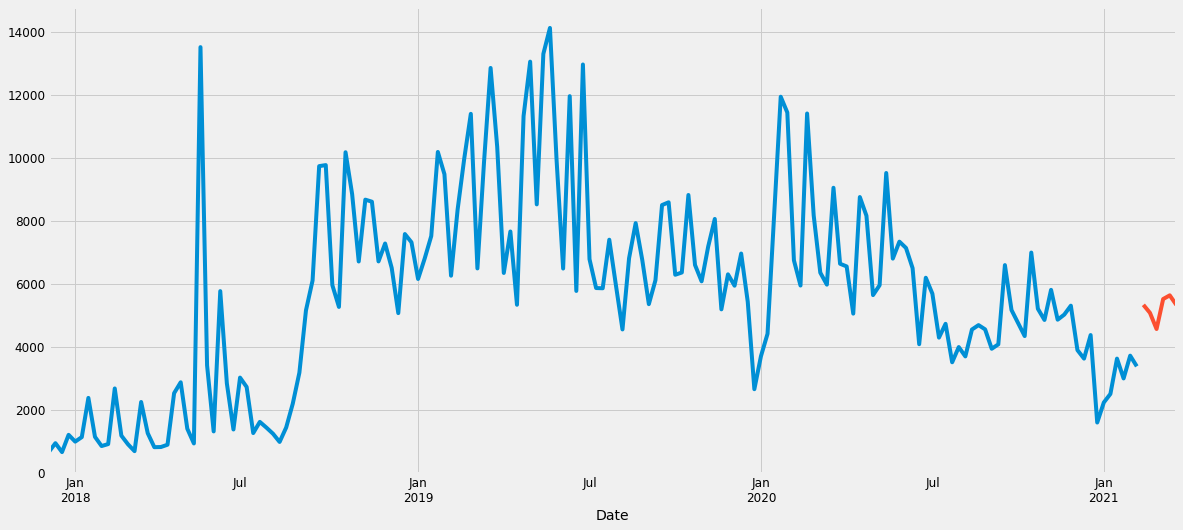

In [15]:
# Viivakaavio havainnoista
df['Saapuneet'].plot()

# Ennusteet kaavioon
df_ennuste['Ennuste'].plot()

In [16]:
# Dataframe, jossa alkuperäinen aikasarja ja lasketut ennusteet
df1 = pd.concat([df, df_ennuste])
df1

,Saapuneet,Ennuste,Ennustevirhe
2017-12-10,663.0,673.756482,-10.756482
2017-12-17,941.0,970.917299,-29.917299
2017-12-24,658.0,688.750824,-30.750824
2017-12-31,1206.0,1279.651994,-73.651994
2018-01-07,991.0,1065.156498,-74.156498
...,...,...,...
2021-02-21,NaN,5077.809365,NaN
2021-02-28,NaN,4565.545868,NaN
2021-03-07,NaN,5516.923387,NaN
2021-03-14,NaN,5634.110283,NaN
